In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

In [2]:
print(os.listdir("data_v4/convert"))

['.ipynb_checkpoints', 'depression', 'violence', 'happiness']


In [3]:
images_dir = "data_v4/convert"
emotion_dirs = os.listdir(images_dir)
emotion_dirs = ['depression', 'violence', 'happiness']

In [4]:
total = 170 + 157 + 219
total

546

In [5]:
weight = {'depression' : 170, 'violence': 157, 'happiness':219}
class_weights = {}
for i in range(3):
    w = total / (3 * weight[emotion_dirs[i]])
    class_weights[i] = w 
class_weights

{0: 1.0705882352941176, 1: 1.1592356687898089, 2: 0.8310502283105022}

In [6]:
batch_size = 32
train_input_shape = (224, 224, 3)
n_classes = 3

train_datagen = ImageDataGenerator(validation_split=0.2,
#                                    rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   featurewise_center=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=emotion_dirs
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=emotion_dirs
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 438 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Total number of batches = 13 and 3


In [7]:
# Load pre-trained model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=train_input_shape, include_preprocessing=True)

for layer in base_model.layers:
    layer.trainable = True

2022-11-18 04:46:27.709795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 04:46:27.710802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 04:46:27.712638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 04:46:27.714571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 04:46:27.715384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [8]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [9]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [10]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/tmp/ipykernel_1965013/4005977698.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
13/13 [==============================] - 323s 21s/step - loss: 1.3345 - accuracy: 0.3867 - val_loss: 2.4482 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 2/20
13/13 [==============================] - 389s 24s/step - loss: 0.9650 - accuracy: 0.4901 - val_loss: 1.7265 - val_accuracy: 0.5208 - lr: 1.0000e-04
Epoch 3/20
13/13 [==============================] - 474s 25s/step - loss: 0.7844 - accuracy: 0.5665 - val_loss: 1.3776 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 4/20
13/13 [==============================] - 567s 31s/step - loss: 0.6686 - accuracy: 0.6330 - val_loss: 1.3708 - val_accuracy: 0.6042 - lr: 1.0000e-04
Epoch 5/20
13/13 [==============================] - 597s 29s/step - loss: 0.5790 - accuracy: 0.7414 - val_loss: 1.4276 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 6/20
13/13 [==============================] - 541s 24s/step - loss: 0.5133 - accuracy: 0.7882 - val_loss: 1.0640 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 7/20
13/13 [============================

In [14]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_3070028/2442743920.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/50
13/13 [==============================] - 370s 20s/step - loss: 0.2328 - accuracy: 1.0000 - val_loss: 0.9518 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/50
13/13 [==============================] - 335s 20s/step - loss: 0.2346 - accuracy: 0.9949 - val_loss: 0.9204 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 3/50
13/13 [==============================] - 332s 19s/step - loss: 0.2537 - accuracy: 0.9949 - val_loss: 0.9737 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 4/50
13/13 [==============================] - 340s 23s/step - loss: 0.2271 - accuracy: 0.9898 - val_loss: 0.9321 - val_accuracy: 0.6042 - lr: 1.0000e-04
Epoch 5/50
13/13 [==============================] - 337s 20s/step - loss: 0.2178 - accuracy: 0.9949 - val_loss: 0.8728 - val_accuracy: 0.6042 - lr: 1.0000e-04
Epoch 6/50
13/13 [==============================] - 348s 26s/step - loss: 0.2254 - accuracy: 0.9949 - val_loss: 0.8933 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 7/50
13/13 [============================

In [ ]:
model.save('efficientnet_data_v6(rescale_temp_78).h5')

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = 'efficientnet_v2_s_childdata.h5'
model = load_model(model_path)

2022-10-29 13:07:11.610466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 13:07:11.611979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 13:07:11.612574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 13:07:11.613149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 13:07:11.613713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 60.9 MB 22.6 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import cv2
import urllib.request

In [4]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype='uint8')
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

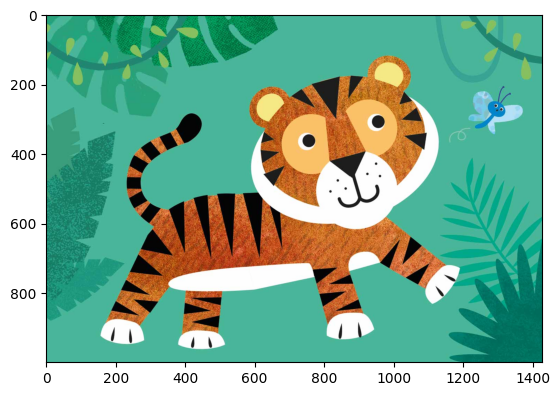

In [7]:
tiger_image = url_to_image('https://bananabearbooks.com/wp-content/uploads/2018/04/tiger-illustration-bananabeabooks.jpg')

plt.imshow(tiger_image)

In [14]:
def Dataization(img):
    image_w = 28
    image_h = 28
    img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
    return (img/256)

In [18]:
img = Dataization(tiger_image)
img

array([[[0.2109375 , 0.68359375, 0.5390625 ],
        [0.17578125, 0.625     , 0.47265625],
        [0.2890625 , 0.7109375 , 0.5859375 ],
        ...,
        [0.28125   , 0.703125  , 0.609375  ],
        [0.28515625, 0.70703125, 0.60546875],
        [0.28515625, 0.70703125, 0.60546875]],

       [[0.2421875 , 0.66796875, 0.546875  ],
        [0.1484375 , 0.6328125 , 0.48828125],
        [0.17578125, 0.64453125, 0.50390625],
        ...,
        [0.27734375, 0.6953125 , 0.6171875 ],
        [0.296875  , 0.71484375, 0.5390625 ],
        [0.28515625, 0.70703125, 0.60546875]],

       [[0.15625   , 0.625     , 0.48828125],
        [0.5234375 , 0.7421875 , 0.390625  ],
        [0.1328125 , 0.64453125, 0.48828125],
        ...,
        [0.13671875, 0.515625  , 0.44140625],
        [0.55078125, 0.74609375, 0.37109375],
        [0.28515625, 0.70703125, 0.60546875]],

       ...,

       [[0.28515625, 0.70703125, 0.60546875],
        [0.28515625, 0.70703125, 0.60546875],
        [0.28515625, 0

In [19]:
img.shape()

TypeError: 'tuple' object is not callable

In [5]:
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = 3

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

In [7]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.4 MB 21.6 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [13]:
import imageio
import cv2
from keras.preprocessing import *
from tensorflow.keras.preprocessing import image

In [9]:
url = 'https://bananabearbooks.com/wp-content/uploads/2018/04/tiger-illustration-bananabeabooks.jpg'

In [14]:
web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)

/tmp/ipykernel_3770608/2914962002.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  web_image = imageio.imread(url)


In [15]:
prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)

1/1 [==============================] - 3s 3s/step


In [16]:
prediction_probability

0.8930141

In [17]:
prediction

array([[0.00582657, 0.10115933, 0.8930141 ]], dtype=float32)

In [18]:
prediction_idx = np.argmax(prediction)

In [20]:
emotion_dirs[prediction_idx]

'happiness'

In [17]:
predictions = model.predict(img)
prediction = np.argmax(predictions[0])

ValueError: in user code:

    File "/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 28, 3)
